# Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles 
This is the code for the paper entitled "[**Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles**](https://arxiv.org/pdf/1910.08635.pdf)" published in IEEE GlobeCom 2019.  
Authors: Li Yang (liyanghart@gmail.com), Abdallah Moubayed, Ismail Hamieh, and Abdallah Shami  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

If you find this repository useful in your research, please cite:  
L. Yang, A. Moubayed, I. Hamieh and A. Shami, "Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles," 2019 IEEE Global Communications Conference (GLOBECOM), 2019, pp. 1-6, doi: 10.1109/GLOBECOM38437.2019.9013892.  

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
import joblib
import os

### Preprocessing (normalization and padding values)

In [3]:
df = pd.read_csv('./data/CICIDS2017_sample.csv')

In [4]:
# Remove Duplicate columns
def remove_duplicate_columns(df):
    columns_to_keep = []
    seen_columns = set()

    for col in df.columns:
        col_hash = df[col].to_string()
        
        if col_hash not in seen_columns:
            columns_to_keep.append(col)
            seen_columns.add(col_hash)

    return df[columns_to_keep]

In [5]:
df = remove_duplicate_columns(df)

In [6]:
df.columns

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'U

In [7]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

### split train set and test set

In [50]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [51]:
X_train.shape

(45328, 62)

### Scaling set

In [52]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [53]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
SCALER_FILENAME = 'models/scaler.joblib' # Define the path to save the scaler
try:
    # Ensure the 'models' directory exists before saving
    os.makedirs('models', exist_ok=True)
    joblib.dump(scaler, SCALER_FILENAME)
    print(f"Fitted scaler saved successfully to {SCALER_FILENAME}")
except Exception as e:
    print(f"Error saving scaler: {e}")

Fitted scaler saved successfully to models/scaler.joblib


In [55]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
Name: count, dtype: int64

### Oversampling by SMOTE

In [56]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy={4: 1500}, random_state=42)

In [57]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [58]:
X_train_resampled_scaled, y_train_sampled = smote.fit_resample(X_train_scaled, y_train)
# X_train_resampled_scaled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [59]:
pd.Series(y_train_scaled).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4     1500
Name: count, dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

Accuracy of DT: 0.995499867643166
Precision of DT: 0.9955266100833206
Recall of DT: 0.995499867643166
F1-score of DT: 0.9955053813890458
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.98      0.98      0.98       393
           2       0.99      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.75      0.86      0.80         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.96      0.97      0.97     11333
weighted avg       1.00      1.00      1.00     11333



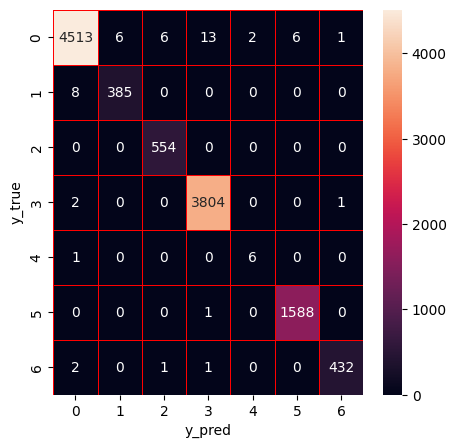

In [61]:
# Decision tree training and prediction
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train_resampled_scaled,y_train_sampled) 
dt_score=dt.score(X_test_scaled,y_test)
y_predict=dt.predict(X_test_scaled)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [62]:
dt_train=dt.predict(X_train_resampled_scaled)
dt_test=dt.predict(X_test_scaled)

Accuracy of RF: 0.9954116297538163
Precision of RF: 0.9954023375197473
Recall of RF: 0.9954116297538163
F1-score of RF: 0.9953871614788563
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.98      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.97      0.98       436

    accuracy                           1.00     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



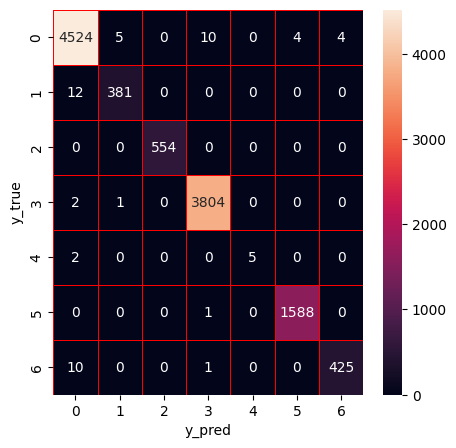

In [63]:
# Random Forest training and prediction
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train_resampled_scaled,y_train_sampled) 
rf_score=rf.score(X_test_scaled,y_test)
y_predict=rf.predict(X_test_scaled)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [64]:
rf_train=rf.predict(X_train_resampled_scaled)
rf_test=rf.predict(X_test_scaled)

Accuracy of ET: 0.9903820700608842
Precision of ET: 0.9904576557067774
Recall of ET: 0.9903820700608842
F1-score of ET: 0.9903764473068586
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4547
           1       0.94      0.97      0.96       393
           2       0.98      1.00      0.99       554
           3       0.99      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       0.98      0.96      0.97       436

    accuracy                           0.99     11333
   macro avg       0.98      0.95      0.96     11333
weighted avg       0.99      0.99      0.99     11333



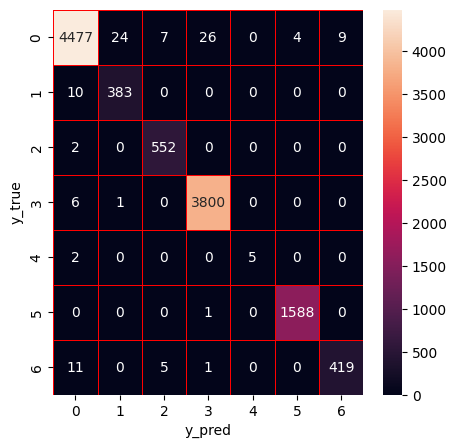

In [65]:
# Extra trees training and prediction
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train_resampled_scaled,y_train_sampled) 
et_score=et.score(X_test_scaled,y_test)
y_predict=et.predict(X_test_scaled)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [69]:
et_train=et.predict(X_train_resampled_scaled)
et_test=et.predict(X_test_scaled)

Accuracy of XGBoost: 0.9944410129709698
Precision of XGBoost: 0.9944283638430056
Recall of XGBoost: 0.9944410129709698
F1-score of XGBoost: 0.994425528148159
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.99      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       0.99      0.99      0.99     11333



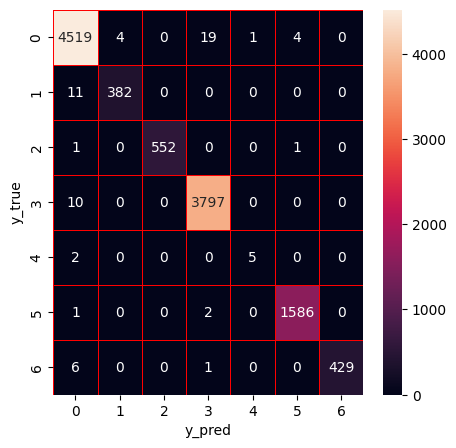

In [70]:
# XGboost training and prediction
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train_resampled_scaled,y_train_sampled)
xg_score=xg.score(X_test_scaled,y_test)
y_predict=xg.predict(X_test_scaled)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [71]:
xg_train=xg.predict(X_train_resampled_scaled)
xg_test=xg.predict(X_test_scaled)

### Stacking model construction (ensemble for 4 base learners)

In [72]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


In [73]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [74]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

In [77]:
stk = xgb.XGBClassifier().fit(x_train,y_train_sampled)

Accuracy of Stacking: 0.995499867643166
Precision of Stacking: 0.9955266100833206
Recall of Stacking: 0.995499867643166
F1-score of Stacking: 0.9955053813890458
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.98      0.98      0.98       393
           2       0.99      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.75      0.86      0.80         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.96      0.97      0.97     11333
weighted avg       1.00      1.00      1.00     11333



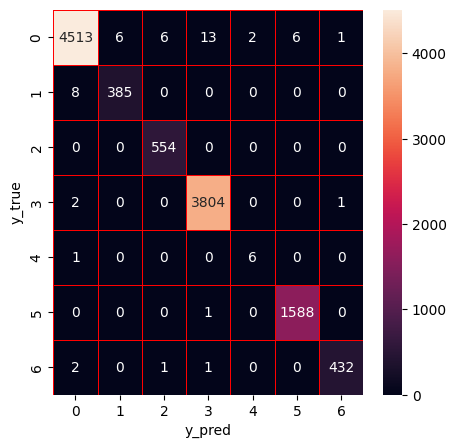

In [78]:
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Feature Selection

### Feature importance

In [79]:
# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

In [80]:
# calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

In [81]:
feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

Features sorted by their score:
[(np.float64(0.1138), 'Bwd Packet Length Std'), (np.float64(0.0954), 'Bwd Packet Length Min'), (np.float64(0.0634), 'Average Packet Size'), (np.float64(0.0501), 'Init_Win_bytes_backward'), (np.float64(0.0446), 'Init_Win_bytes_forward'), (np.float64(0.0411), 'Bwd Packet Length Mean'), (np.float64(0.0403), 'PSH Flag Count'), (np.float64(0.0375), 'Bwd Packets/s'), (np.float64(0.0283), 'Fwd Header Length'), (np.float64(0.0249), 'Packet Length Std'), (np.float64(0.0242), 'Bwd Packet Length Max'), (np.float64(0.0236), 'Avg Bwd Segment Size'), (np.float64(0.0219), 'Bwd Header Length'), (np.float64(0.0218), 'Packet Length Variance'), (np.float64(0.0216), 'Packet Length Mean'), (np.float64(0.0199), 'min_seg_size_forward'), (np.float64(0.018), 'Flow IAT Std'), (np.float64(0.0177), 'act_data_pkt_fwd'), (np.float64(0.0174), 'Total Length of Fwd Packets'), (np.float64(0.015), 'Fwd PSH Flags'), (np.float64(0.0143), 'Max Packet Length'), (np.float64(0.0125), 'Fwd IAT M

In [82]:
f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)

In [83]:
f_list

[(np.float64(0.1138), 'Bwd Packet Length Std'),
 (np.float64(0.0954), 'Bwd Packet Length Min'),
 (np.float64(0.0634), 'Average Packet Size'),
 (np.float64(0.0501), 'Init_Win_bytes_backward'),
 (np.float64(0.0446), 'Init_Win_bytes_forward'),
 (np.float64(0.0411), 'Bwd Packet Length Mean'),
 (np.float64(0.0403), 'PSH Flag Count'),
 (np.float64(0.0375), 'Bwd Packets/s'),
 (np.float64(0.0283), 'Fwd Header Length'),
 (np.float64(0.0249), 'Packet Length Std'),
 (np.float64(0.0242), 'Bwd Packet Length Max'),
 (np.float64(0.0236), 'Avg Bwd Segment Size'),
 (np.float64(0.0219), 'Bwd Header Length'),
 (np.float64(0.0218), 'Packet Length Variance'),
 (np.float64(0.0216), 'Packet Length Mean'),
 (np.float64(0.0199), 'min_seg_size_forward'),
 (np.float64(0.018), 'Flow IAT Std'),
 (np.float64(0.0177), 'act_data_pkt_fwd'),
 (np.float64(0.0174), 'Total Length of Fwd Packets'),
 (np.float64(0.015), 'Fwd PSH Flags'),
 (np.float64(0.0143), 'Max Packet Length'),
 (np.float64(0.0125), 'Fwd IAT Max'),
 (np.

In [84]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [85]:
fs

['Bwd Packet Length Std',
 'Bwd Packet Length Min',
 'Average Packet Size',
 'Init_Win_bytes_backward',
 'Init_Win_bytes_forward',
 'Bwd Packet Length Mean',
 'PSH Flag Count',
 'Bwd Packets/s',
 'Fwd Header Length',
 'Packet Length Std',
 'Bwd Packet Length Max',
 'Avg Bwd Segment Size',
 'Bwd Header Length',
 'Packet Length Variance',
 'Packet Length Mean',
 'min_seg_size_forward',
 'Flow IAT Std',
 'act_data_pkt_fwd',
 'Total Length of Fwd Packets',
 'Fwd PSH Flags',
 'Max Packet Length',
 'Fwd IAT Max',
 'Min Packet Length',
 'Total Fwd Packets',
 'ACK Flag Count',
 'Fwd Packet Length Mean',
 'Total Backward Packets',
 'Total Length of Bwd Packets',
 'Fwd IAT Mean',
 'Fwd Packet Length Max',
 'Flow Duration',
 'Down/Up Ratio',
 'Fwd IAT Min',
 'URG Flag Count',
 'Bwd IAT Total',
 'Subflow Bwd Bytes']

In [86]:
X_fs = df[fs].values

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [88]:
X_train.shape

(45328, 36)

### Scaling Set

In [89]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [90]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [91]:
SCALER_FILENAME = 'models/scaler.joblib' # Define the path to save the scaler
try:
    # Ensure the 'models' directory exists before saving
    os.makedirs('models', exist_ok=True)
    joblib.dump(scaler, SCALER_FILENAME)
    print(f"Fitted scaler saved successfully to {SCALER_FILENAME}")
except Exception as e:
    print(f"Error saving scaler: {e}")

Fitted scaler saved successfully to models/scaler.joblib


In [92]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
Name: count, dtype: int64

### Oversampling by SMOTE

In [93]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy={4: 1500}, random_state=42)

In [94]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)
X_train_resampled_scaled, y_train_sampled = smote.fit_resample(X_train_scaled, y_train)

In [95]:
pd.Series(y_train_sampled).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4     1500
Name: count, dtype: int64

## Machine learning model training after feature selection

Accuracy of DT: 0.9958528192005647
Precision of DT: 0.995842828012723
Recall of DT: 0.9958528192005647
F1-score of DT: 0.9958406860596141
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.99      0.98      0.99       393
           2       0.99      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       1.00      1.00      1.00     11333



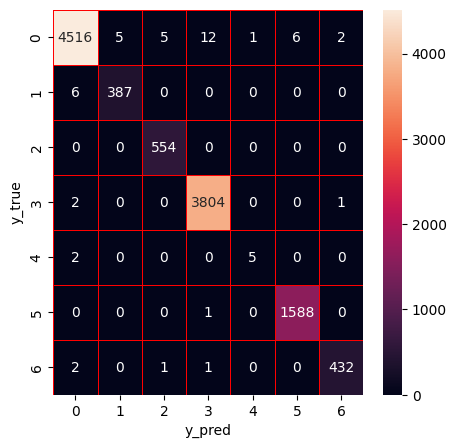

In [96]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train_resampled_scaled,y_train_sampled) 
dt_score=dt.score(X_test_scaled,y_test)
y_predict=dt.predict(X_test_scaled)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [97]:
dt_train=dt.predict(X_train_resampled_scaled)
dt_test=dt.predict(X_test_scaled)

Accuracy of RF: 0.9969999117621107
Precision of RF: 0.997000308421435
Recall of RF: 0.9969999117621107
F1-score of RF: 0.9969811827983951
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



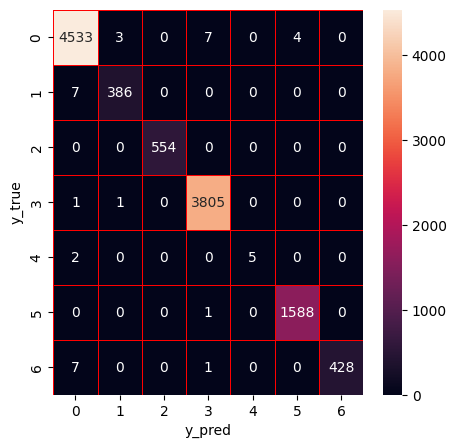

In [98]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train_resampled_scaled,y_train_sampled) # modelin veri üzerinde öğrenmesi fit fonksiyonuyla yapılıyor
rf_score=rf.score(X_test_scaled,y_test)
y_predict=rf.predict(X_test_scaled)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
rf_train=rf.predict(X_train_resampled_scaled)
rf_test=rf.predict(X_test_scaled)

In [ ]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train_resampled_scaled,y_train_sampled) 
et_score=et.score(X_test_scaled,y_test)
y_predict=et.predict(X_test_scaled)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
et_train=et.predict(X_train_resampled_scaled)
et_test=et.predict(X_test_scaled)

Accuracy of XGBoost: 0.9939998235242213
Precision of XGBoost: 0.9939940176289752
Recall of XGBoost: 0.9939998235242213
F1-score of XGBoost: 0.9939785251890281
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       1.00      0.96      0.98       393
           2       1.00      0.99      1.00       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       0.99      0.99      0.99     11333



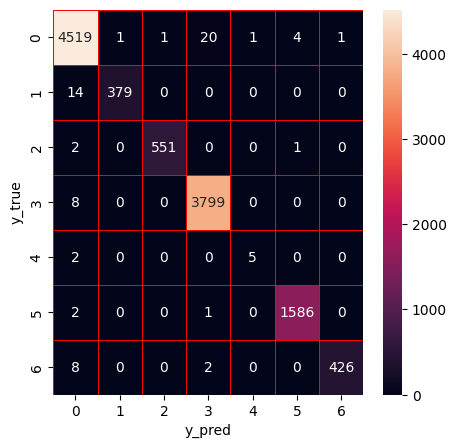

In [99]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train_resampled_scaled,y_train_sampled)
xg_score=xg.score(X_test_scaled,y_test)
y_predict=xg.predict(X_test_scaled)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [100]:
xg_train=xg.predict(X_train_resampled_scaled)
xg_test=xg.predict(X_test_scaled)

### Stacking model construction

In [101]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


In [102]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [103]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9958528192005647
Precision of Stacking: 0.995842828012723
Recall of Stacking: 0.9958528192005647
F1-score of Stacking: 0.9958406860596141
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.99      0.98      0.99       393
           2       0.99      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       1.00      1.00      1.00     11333



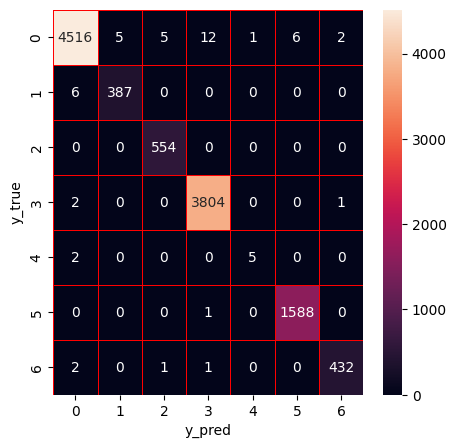

In [104]:
stk = xgb.XGBClassifier().fit(x_train, y_train_sampled)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [105]:
fs

['Bwd Packet Length Std',
 'Bwd Packet Length Min',
 'Average Packet Size',
 'Init_Win_bytes_backward',
 'Init_Win_bytes_forward',
 'Bwd Packet Length Mean',
 'PSH Flag Count',
 'Bwd Packets/s',
 'Fwd Header Length',
 'Packet Length Std',
 'Bwd Packet Length Max',
 'Avg Bwd Segment Size',
 'Bwd Header Length',
 'Packet Length Variance',
 'Packet Length Mean',
 'min_seg_size_forward',
 'Flow IAT Std',
 'act_data_pkt_fwd',
 'Total Length of Fwd Packets',
 'Fwd PSH Flags',
 'Max Packet Length',
 'Fwd IAT Max',
 'Min Packet Length',
 'Total Fwd Packets',
 'ACK Flag Count',
 'Fwd Packet Length Mean',
 'Total Backward Packets',
 'Total Length of Bwd Packets',
 'Fwd IAT Mean',
 'Fwd Packet Length Max',
 'Flow Duration',
 'Down/Up Ratio',
 'Fwd IAT Min',
 'URG Flag Count',
 'Bwd IAT Total',
 'Subflow Bwd Bytes']

In [106]:
import joblib

joblib.dump(dt, "decision_tree_model.pkl")
print("decision_tree_model: Model saved successfully!")

joblib.dump(rf,"random_forest_model.pkl")
print("random_forest_model: Model saved successfully!")

joblib.dump(et,"extra_trees_model.pkl")
print("extra_trees_model: Model saved successfully!")

joblib.dump(xg,"xgboost_model.pkl")
print("xgboost_model: Model saved successfully!")

# Save the trained model
joblib.dump(stk, "xgboost_best_stacked_model.pkl")
print("xgboost_best_stacked_model: Model saved successfully!")


# Save the feature list to a file
joblib.dump(fs, "selected_features.pkl")
print("Selected features saved successfully!")

joblib.dump(labelencoder,"label_encoder.pkl")
print("Labelencoder saved successfully!")

pd.DataFrame(fs, columns=["Features"]).to_csv("selected_features.csv", index=False)


decision_tree_model: Model saved successfully!
random_forest_model: Model saved successfully!
extra_trees_model: Model saved successfully!
xgboost_model: Model saved successfully!
xgboost_best_stacked_model: Model saved successfully!
Selected features saved successfully!
Labelencoder saved successfully!
